# Make Slope and Elevation Heatmaps

In [33]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.cm import ScalarMappable
import matplotlib.ticker
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

## Load in the Data:

In [5]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

In [12]:
tum_elev = 2621.28
dan_elev = 2965

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [6]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus'] - atl06sr_gdf['diff_plus'].mean()) / atl06sr_gdf['diff_plus'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [7]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

## Make the Heatmaps

In [8]:
import seaborn as sns

In [10]:
metric_atl06_list = [atl06sr_gdf[inner_snowoff_idx]['diff_plus'],
                     atl06sr_gdf[inner_snowon_idx]['diff_plus'],
                     atl06sr_gdf[inner_snowoff_idx]['diff_plus'],
                     atl06sr_gdf[inner_snowon_idx]['diff_plus']]
metric_list = [atl06sr_gdf[inner_snowoff_idx]['slope_20m'],
               atl06sr_gdf[inner_snowon_idx]['slope_20m'],
               atl06sr_gdf[inner_snowoff_idx]['h_mean'],
               atl06sr_gdf[inner_snowon_idx]['h_mean']]

range_list = [[[0,50], [-4,4]],[[0,50], [-4,4]], [[1000,3500],[-2,2]], [[1000,3500],[-2,2]]]

In [71]:
def heatmap_atl06sr(df, col='diff_plus', metric_col='slope_20m', range_list=range_list, norm=None):
    fig, axa = plt.subplots(2,2,sharex='col',sharey=True,figsize=(10,10))
    
    # Plot the upper right heatmap
    sm = axa[0,1].hist2d(df[inner_snowoff_idx][metric_col], \
        df[inner_snowoff_idx][col], bins = 60, \
        range = [[0,40], [-4,4]],norm=norm)
    
    # Plot the upper left heatmap
    axa[0,0].hist2d(df[inner_snowoff_idx]['h_mean'], \
        df[inner_snowoff_idx][col], bins = 60, \
        range = [[2000,3500],[-4,4]], norm=norm)
    axa[0,0].axvline(x=tum_elev, c='w', linewidth=1)
    axa[0,0].axvline(x=dan_elev, c='w', linewidth=1)

    # Plot the lower right heatmap
    axa[1,1].hist2d(df[inner_snowon_idx][metric_col], \
        df[inner_snowon_idx][col], bins = 60, \
        range = [[0,40], [-4,4]],norm=norm)

    # Plot the lower left heatmap
    axa[1,0].hist2d(df[inner_snowon_idx]['h_mean'], \
        df[inner_snowon_idx][col], bins = 60, \
        range = [[2000,3500],[-4,4]], norm=norm)    


    for ax in axa.flatten():
        ax.axhline(y=0, c='k', linewidth=1, alpha=.2)
    
    axa[1,0].axvline(x=tum_elev, c='w', linewidth=1)
    axa[1,0].axvline(x=dan_elev, c='w', linewidth=1)
    
    axa[1,0].set_ylabel('Snow On')
    axa[0,0].set_ylabel('Snow Off')
    axa[0,1].set_title('Slope (degrees)')
    axa[0,0].set_title('Elevation (m)')

    cbar = fig.colorbar(sm[3], ax=axa[:,1], format=matplotlib.ticker.ScalarFormatter())
    cbar.set_label("Count")

    fig.supylabel('Elevation Difference: ATL06SR - DEM (m)')
    #fig.savefig('../figures/heatmap_matrix.jpeg', dpi=500);

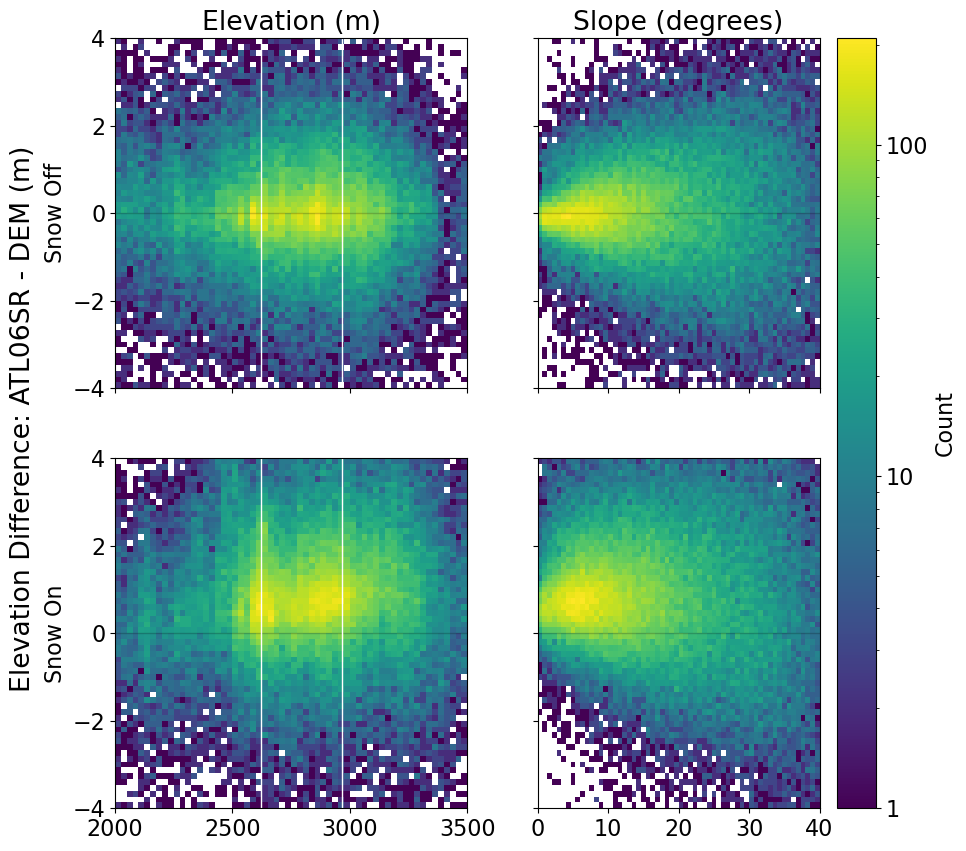

In [72]:
heatmap_atl06sr(atl06sr_gdf, 'diff_plus', 'slope_20m', range_list, 'log')

## Add Line of Most Frequent Value

In [152]:
def heatmap_atl06sr(df, col='diff_plus', metric_col='slope_20m', range_list=range_list, norm=None):
    fig, axa = plt.subplots(2,2,sharex='col',sharey=True,figsize=(10,10))
    
    # Plot the upper left heatmap
    H0, xedges0, yedges0, sm0 = axa[0,0].hist2d(df[inner_snowoff_idx]['h_mean'], \
        df[inner_snowoff_idx][col], bins = 60, \
        range = [[2000,3500],[-4,4]], norm=norm)
    
    # Plot the upper right heatmap
    H1, xedges1, yedges1, sm1 = axa[0,1].hist2d(df[inner_snowoff_idx][metric_col], \
        df[inner_snowoff_idx][col], bins = 60, \
        range = [[0,40], [-4,4]],norm=norm)
    
    # Plot the lower left heatmap
    H2, xedges2, yedges2, sm2 = axa[1,0].hist2d(df[inner_snowon_idx]['h_mean'], \
        df[inner_snowon_idx][col], bins = 60, \
        range = [[2000,3500],[-4,4]], norm=norm)
    
    # Plot the lower right heatmap
    H3, xedges3, yedges3, sm3 = axa[1,1].hist2d(df[inner_snowon_idx][metric_col], \
        df[inner_snowon_idx][col], bins = 60, \
        range = [[0,40], [-4,4]],norm=norm)    

    # code for plotting the most common values on the heatmaps is from David Shean:
    # https://github.com/geohackweek/tutorial_contents/blob/master/raster/notebooks/rainier_dem_example.ipynb
    H_list = [H0, H1, H2, H3]
    xedges_list = [xedges0, xedges1, xedges2, xedges3]
    yedges_list = [yedges0, yedges1, yedges2, yedges3]

    for ax, H, xedges, yedges in zip(axa.flatten(), H_list, xedges_list, yedges_list):
        ax.axhline(y=0, c='k', linewidth=1, alpha=.2)
        H = np.rot90(H)
        H = np.flipud(H)
        Hmasked = np.ma.masked_where(H==0,H)
        Hmax_idx = np.ma.argmax(Hmasked, axis=0)
        ymax = (yedges[:-1]+np.diff(yedges))[Hmax_idx]
        ax.plot(xedges[:-1]+np.diff(xedges), ymax, color='k',lw=1.0, alpha=0.8)
    
    axa[0,0].axvline(x=tum_elev, c='w', linewidth=1)
    axa[0,0].axvline(x=dan_elev, c='w', linewidth=1)
    axa[0,0].text(dan_elev-100,-4.6,'DAN')
    axa[0,0].text(tum_elev-100,-4.6,'TUM')
    axa[1,0].axvline(x=tum_elev, c='w', linewidth=1)
    axa[1,0].axvline(x=dan_elev, c='w', linewidth=1)
    
    axa[1,0].set_ylabel('Snow On')
    axa[0,0].set_ylabel('Snow Off')
    axa[0,1].set_title('Slope (degrees)')
    axa[0,0].set_title('Elevation (m)')

    cbar = fig.colorbar(sm0, ax=axa[:,1], format=matplotlib.ticker.ScalarFormatter())
    cbar.set_label("Value Count")

    fig.supylabel('Elevation Difference: ATL06SR - DEM (m)')
    fig.savefig('../../figures/polished/heatmap_matrix.jpeg', dpi=500);

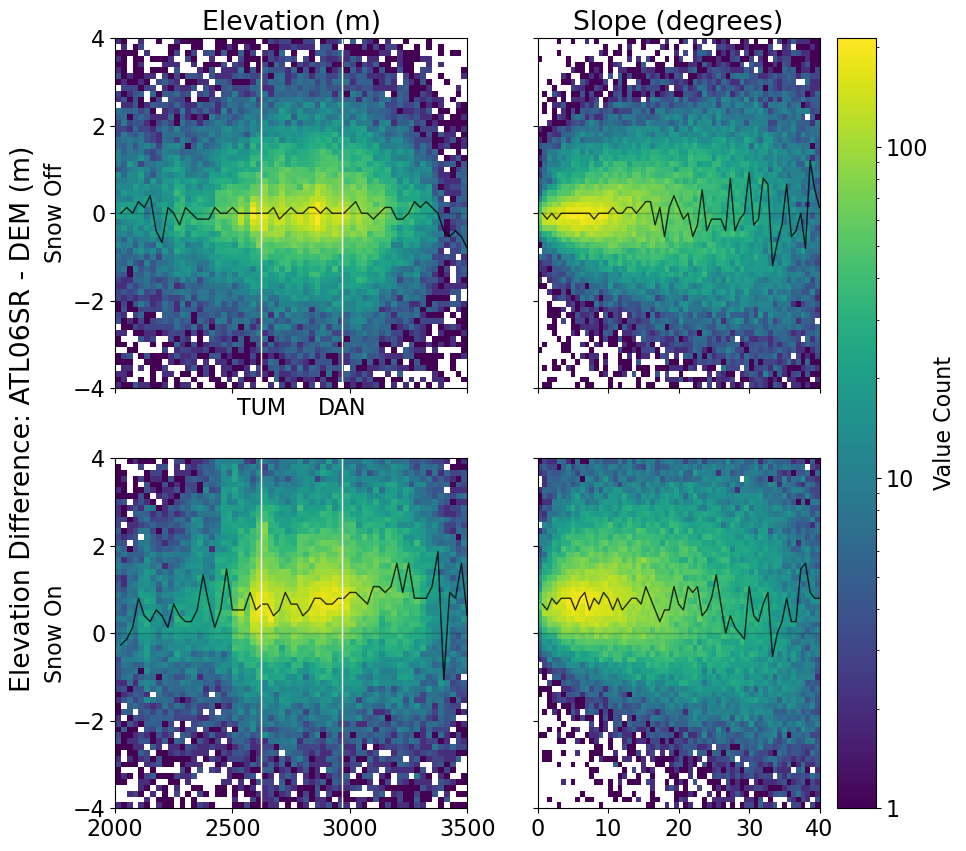

In [153]:
heatmap_atl06sr(atl06sr_gdf, 'diff_plus', 'slope_3m', range_list, norm='log')

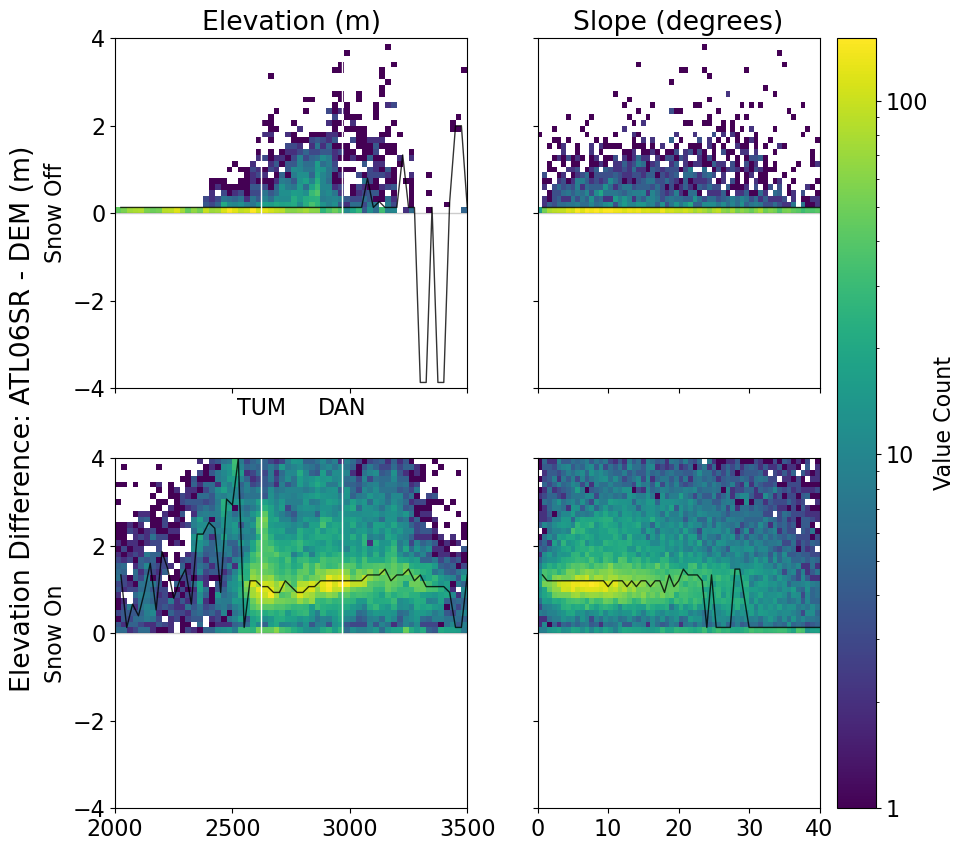

In [150]:
heatmap_atl06sr(atl06sr_gdf, 'ASO_snowon', 'slope_3m', range_list, 'log')

In [151]:
def heatmap_aso(df, col='diff_plus', metric_col='slope_20m', range_list=range_list, norm=None):
    fig, axa = plt.subplots(2,2,sharex='col',sharey=True,figsize=(10,10))
    
    # Plot the upper left heatmap
    H0, xedges0, yedges0, sm0 = axa[0,0].hist2d(df[inner_snowoff_idx]['h_mean'], \
        df[inner_snowoff_idx][col], bins = 60, \
        range = [[2000,3500],[-4,4]], norm=norm)
    
    # Plot the upper right heatmap
    H1, xedges1, yedges1, sm1 = axa[0,1].hist2d(df[inner_snowoff_idx][metric_col], \
        df[inner_snowoff_idx][col], bins = 60, \
        range = [[0,40], [-4,4]],norm=norm)
    
    # Plot the lower left heatmap
    H2, xedges2, yedges2, sm2 = axa[1,0].hist2d(df[inner_snowon_idx]['h_mean'], \
        df[inner_snowon_idx][col], bins = 60, \
        range = [[2000,3500],[-4,4]], norm=norm)
    
    # Plot the lower right heatmap
    H3, xedges3, yedges3, sm3 = axa[1,1].hist2d(df[inner_snowon_idx][metric_col], \
        df[inner_snowon_idx][col], bins = 60, \
        range = [[0,40], [-4,4]],norm=norm)    

    # code for plotting the most common values on the heatmaps is from David Shean:
    # https://github.com/geohackweek/tutorial_contents/blob/master/raster/notebooks/rainier_dem_example.ipynb
    H_list = [H0, H1, H2, H3]
    xedges_list = [xedges0, xedges1, xedges2, xedges3]
    yedges_list = [yedges0, yedges1, yedges2, yedges3]

    for ax, H, xedges, yedges in zip(axa.flatten(), H_list, xedges_list, yedges_list):
        ax.axhline(y=0, c='k', linewidth=1, alpha=.2)
        H = np.rot90(H)
        H = np.flipud(H)
        Hmasked = np.ma.masked_where(H==0,H)
        Hmax_idx = np.ma.argmax(Hmasked, axis=0)
        ymax = (yedges[:-1]+np.diff(yedges))[Hmax_idx]
        ax.plot(xedges[:-1]+np.diff(xedges), ymax, color='k',lw=1.0, alpha=0.8)
    
    axa[0,0].axvline(x=tum_elev, c='w', linewidth=1)
    axa[0,0].axvline(x=dan_elev, c='w', linewidth=1)
    axa[0,0].text(dan_elev-100,-4.6,'DAN')
    axa[0,0].text(tum_elev-100,-4.6,'TUM')
    axa[1,0].axvline(x=tum_elev, c='w', linewidth=1)
    axa[1,0].axvline(x=dan_elev, c='w', linewidth=1)
    
    axa[1,0].set_ylabel('Snow On')
    axa[0,0].set_ylabel('Snow Off')
    axa[0,1].set_title('Slope (degrees)')
    axa[0,0].set_title('Elevation (m)')

    cbar = fig.colorbar(sm0, ax=axa[:,1], format=matplotlib.ticker.ScalarFormatter())
    cbar.set_label("Value Count")

    fig.supylabel('Elevation Difference: ATL06SR - DEM (m)')
    #fig.savefig('../figures/heatmap_matrix.jpeg', dpi=500);